# 1.) Import the data from CCLE into a new Google Colab file

In [1]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/gdrive/', force_remount = True)

Mounted at /content/gdrive/


In [3]:
df=pd.read_csv("/content/gdrive/MyDrive/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
df.loc[df['smoker']=='yes','smoker']=1
df.loc[df['smoker']=='no','smoker']=0

In [5]:
df.loc[df['sex']=='female','sex']=1
df.loc[df['sex']=='male','sex']=0

In [6]:
df.loc[df['region']=='southwest','region']=1
df.loc[df['region']=='northwest','region']=2
df.loc[df['region']=='southeast','region']=3
df.loc[df['region']=='northeast','region']=4

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,1,27.900,0,1,1,16884.92400
1,18,0,33.770,1,0,3,1725.55230
2,28,0,33.000,3,0,3,4449.46200
3,33,0,22.705,0,0,2,21984.47061
4,32,0,28.880,0,0,2,3866.85520


# 2.) Split the data into 80/20, in/out sample

In [8]:
import numpy as np

In [9]:
from pandas.core.arrays.sparse import array
data=np.array(df.iloc[:,:-1])
target=np.array(df.iloc[:,-1])

In [10]:
cut=int((len(data)*.8)//1)

In [11]:
in_data=data[:cut]
out_data=data[cut:]

in_target=target[:cut]
out_target=target[cut:]

# 3.) Normalize the Data

In [12]:
from sklearn import preprocessing

In [13]:
scaler1=preprocessing.StandardScaler().fit(in_data)
scaler2=preprocessing.StandardScaler().fit(out_data)
in_data_scale=scaler1.transform(in_data)
out_data_scale=scaler2.transform(out_data)

# 4.) Get lambda from Lasso cross validation

In [14]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso

In [15]:
modCV1=LassoCV().fit(in_data_scale,in_target)
a_in=modCV1.alpha_
a_in

176.27926602952408

In [16]:
modCV2=LassoCV().fit(out_data_scale,out_target)
a_out=modCV2.alpha_
a_out

115.03927421975118

# 5.) Run a Lasso regression with that Lambda

In [18]:
mod1=Lasso(alpha=a_in).fit(in_data_scale,in_target)

In [19]:
mod2=Lasso(alpha=a_out).fit(out_data_scale,out_target)

# 6.) Visualize the coefficients 

In [23]:
mod1.predict(np.array(in_data_scale))
mod1.coef_

array([3683.59361506,  110.79283002, 1954.18867448,  528.65754774,
       9455.16094537,  337.76434542])

In [22]:
mod2.predict(np.array(out_data_scale))
mod2.coef_

array([ 3276.54079231,   -95.01653532,  1855.5825659 ,   605.44085886,
       10028.75157179,   -40.86527975])

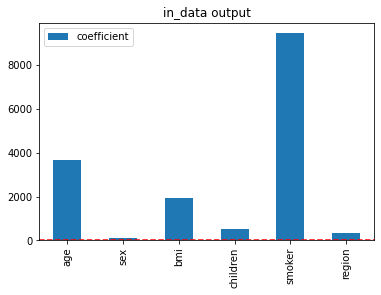

In [28]:
indata=pd.DataFrame(mod1.coef_,index=["age","sex","bmi","children","smoker","region"],columns=["coefficient"])
indata.plot(kind="bar",title="in_data output")
plt.axhline(y=0,color="red",linestyle="--")

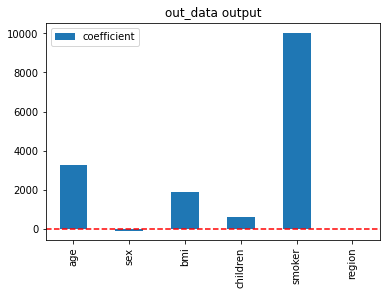

In [29]:
outdata=pd.DataFrame(mod2.coef_,index=["age","sex","bmi","children","smoker","region"],columns=["coefficient"])
outdata.plot(kind="bar",title="out_data output")
plt.axhline(y=0,color="red",linestyle="--")

# 7.) Interpret the coefficients

In Sample

The coefficient of age is 3683.59, which means that when age increases by 1, the charge will increase by about 3683.59 when holding other variables constant.

The coefficient of sex is 110.8, which means female will be charged $110.8 more than male when holding other variables constant.

The coefficient of bmi is 1954.59, which means that when bim increases by 1, the charge will increase by about 1954.59 when holding other variables constant.

The coefficient of children is 528.66, which means that when children increases by 1, the charge will increase by about 528.66 when holding other variables constant.

The coefficient of smoker is 9455.66, which means that smokers will be charged higher than non-smokers with about 9455.16.

The coefficient of region is 337.76, which means that different region charge differently.




Out Sample

The coefficient of age is 3276.54, which means that when age increases by 1, the charge will increase by about 3276.54 when holding other variables constant.

The coefficient of sex is 95.02, which means female will be charged 95.02 less than male when holding other variables constant.

The coefficient of bmi is 1855.58, which means that when bim increases by 1, the charge will increase by about 1855.58 when holding other variables constant.

The coefficient of children is 605.44, which means that when children increases by 1, the charge will increase by about 605.44 when holding other variables constant.

The coefficient of smoker is 10028.75, which means that smokers will be charged higher than non-smokers with about 10028.75.

The coefficient of region is -40.86, which means that different region charge differently.


# 8.) Compare in and out of sample MSE’s

In [31]:
import sklearn as sk

In [32]:
sk.metrics.mean_squared_error(in_target,mod1.predict(in_data_scale))

36500145.744634956

In [33]:
sk.metrics.mean_squared_error(out_target,mod2.predict(out_data_scale))

36624524.24462681